In [1]:
import pandas as pd
import scanpy as sc
import numpy as np
import scipy
import matplotlib.pyplot as plt
import rpy2
from matplotlib import rcParams # for figure size adjustment
import os

# Load data

In [2]:
data_path = "../../OneDrive/Documents/scData/hiv/processed_data/"


def load_data (file_name):
    tdata = sc.read_10x_h5(data_path + file_name)
    
    # Some variables can be the same name, which could make errors in the downstream analysis.
    # Add numbers (1, 2, 3, ...) to the variables to make the variables unique.
    tdata.var_names_make_unique()
    
    print(f"The shape of the dataset: n_obs {tdata.shape[0]} x n_vars {tdata.shape[1]}.")
    print("Init barcode count:", tdata.shape[0])
    print("Init_gene_count:", tdata.shape[1], "\n")
    return tdata
    
normal_1 = load_data("normal_1_filtered_feature_bc_matrix.h5")
normal_2 = load_data("normal_2_filtered_feature_bc_matrix.h5")
normal_3 = load_data("normal_3_filtered_feature_bc_matrix.h5")
hiv_1 = load_data("hiv_1_filtered_feature_bc_matrix.h5")
hiv_2 = load_data("hiv_2_filtered_feature_bc_matrix.h5")
hiv_3 = load_data("hiv_3_filtered_feature_bc_matrix.h5")

c:\Users\heung\anaconda3\Lib\site-packages\anndata\_core\anndata.py:1820: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
c:\Users\heung\anaconda3\Lib\site-packages\anndata\_core\anndata.py:1820: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


The shape of the dataset: n_obs 10915 x n_vars 38606.
Init barcode count: 10915
Init_gene_count: 38606 



c:\Users\heung\anaconda3\Lib\site-packages\anndata\_core\anndata.py:1820: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
c:\Users\heung\anaconda3\Lib\site-packages\anndata\_core\anndata.py:1820: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


The shape of the dataset: n_obs 6453 x n_vars 38606.
Init barcode count: 6453
Init_gene_count: 38606 



c:\Users\heung\anaconda3\Lib\site-packages\anndata\_core\anndata.py:1820: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
c:\Users\heung\anaconda3\Lib\site-packages\anndata\_core\anndata.py:1820: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


The shape of the dataset: n_obs 10765 x n_vars 38606.
Init barcode count: 10765
Init_gene_count: 38606 



c:\Users\heung\anaconda3\Lib\site-packages\anndata\_core\anndata.py:1820: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
c:\Users\heung\anaconda3\Lib\site-packages\anndata\_core\anndata.py:1820: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


The shape of the dataset: n_obs 6500 x n_vars 38606.
Init barcode count: 6500
Init_gene_count: 38606 



c:\Users\heung\anaconda3\Lib\site-packages\anndata\_core\anndata.py:1820: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
c:\Users\heung\anaconda3\Lib\site-packages\anndata\_core\anndata.py:1820: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


The shape of the dataset: n_obs 8960 x n_vars 38606.
Init barcode count: 8960
Init_gene_count: 38606 

The shape of the dataset: n_obs 9433 x n_vars 38606.
Init barcode count: 9433
Init_gene_count: 38606 



c:\Users\heung\anaconda3\Lib\site-packages\anndata\_core\anndata.py:1820: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
c:\Users\heung\anaconda3\Lib\site-packages\anndata\_core\anndata.py:1820: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


In [3]:
print(normal_1, "\n")
print(normal_2, "\n")
print(normal_3, "\n")
print(hiv_1, "\n")
print(hiv_2, "\n")
print(hiv_3, "\n")

AnnData object with n_obs × n_vars = 10915 × 38606
    var: 'gene_ids', 'feature_types', 'genome' 

AnnData object with n_obs × n_vars = 6453 × 38606
    var: 'gene_ids', 'feature_types', 'genome' 

AnnData object with n_obs × n_vars = 10765 × 38606
    var: 'gene_ids', 'feature_types', 'genome' 

AnnData object with n_obs × n_vars = 6500 × 38606
    var: 'gene_ids', 'feature_types', 'genome' 

AnnData object with n_obs × n_vars = 8960 × 38606
    var: 'gene_ids', 'feature_types', 'genome' 

AnnData object with n_obs × n_vars = 9433 × 38606
    var: 'gene_ids', 'feature_types', 'genome' 



# Quality control

## Basic cell filtering

In [4]:
for adata in [normal_1, normal_2, normal_3, hiv_1, hiv_2, hiv_3]:
    sc.pp.filter_cells(adata, min_genes = 200)
    sc.pp.filter_genes(adata, min_cells = 3)

## Draw QC plots

In [5]:
# annotate genes to adata
for adata in [normal_1, normal_2, normal_3, hiv_1, hiv_2, hiv_3]:
    # mitochondrial genes
    adata.var["MT"] = adata.var_names.str.startswith("MT-")
    # ribosomal genes
    adata.var["ribo"] = adata.var_names.str.startswith("RPS") | adata.var_names.str.startswith("RPL")
    # hemoglobin genes.
    # adata.var["hb"] = adata.var_names.str.contains("^HB[^(p)]")
    # Malat1
    adata.var["MALAT1"] = adata.var_names.str.contains("MALAT1")
    
    sc.pp.calculate_qc_metrics(
        adata,
        qc_vars = ["MT", "ribo", "MALAT1"],
        inplace = True,
        percent_top = [20],
        log1p = True
    )


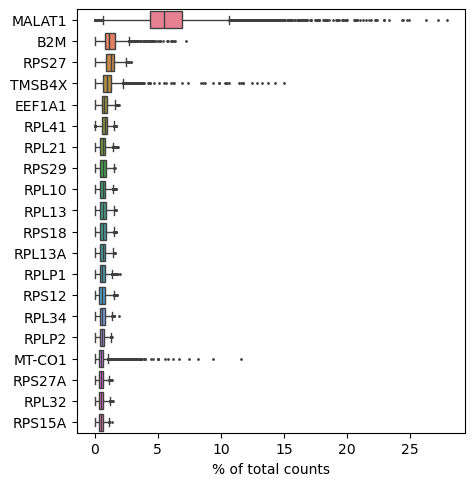

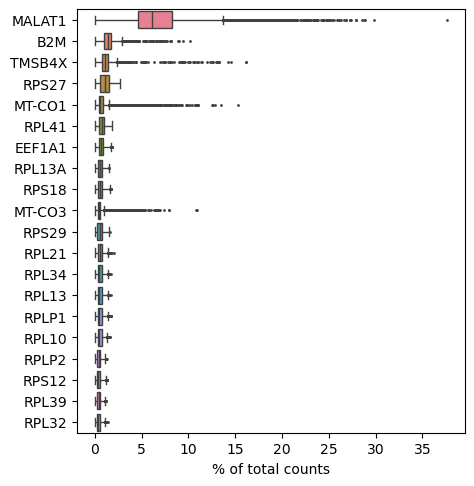

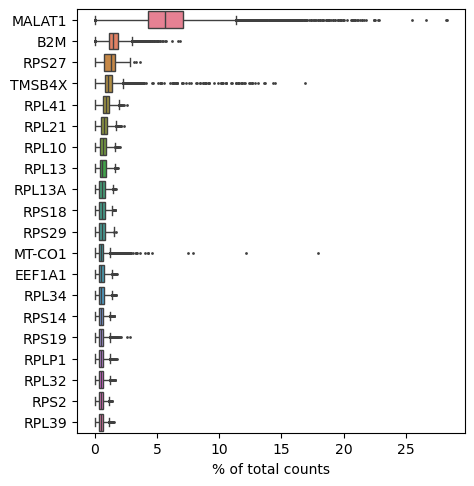

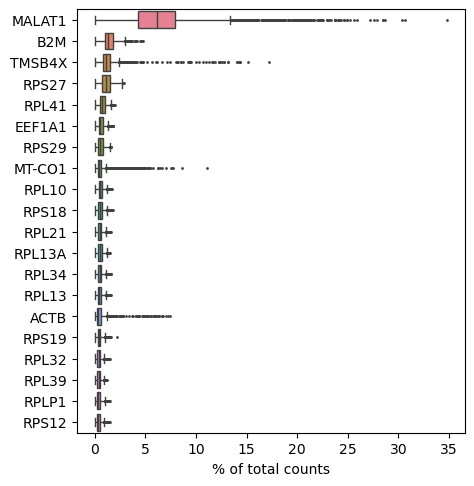

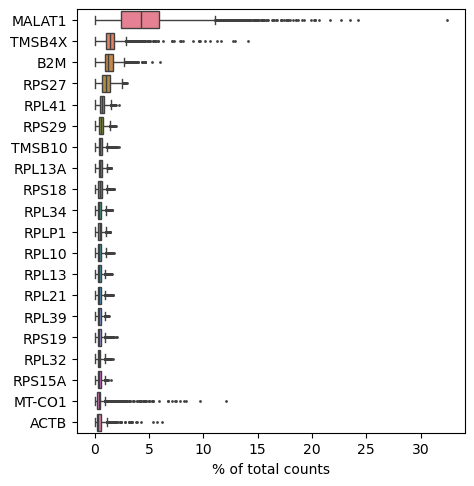

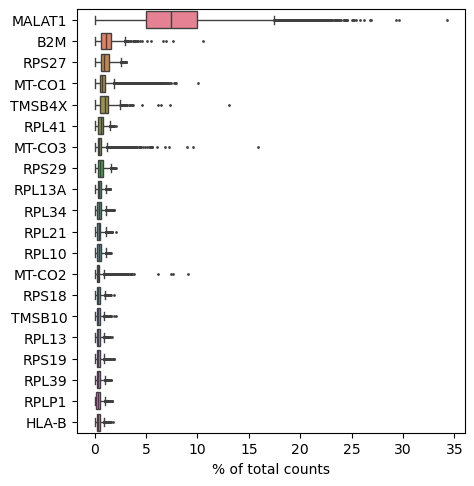

In [6]:
# Highest expressed gene plots

for adata in [normal_1, normal_2, normal_3, hiv_1, hiv_2, hiv_3]:
    sc.pl.highest_expr_genes(adata, n_top = 20)
    # MALAT1 frequently detected in RNA-seq data captured by poly-A
    # A technical bias need to remove
    # RPS, RPL: ribosomal genes
    # MT-: mitochondrial genes

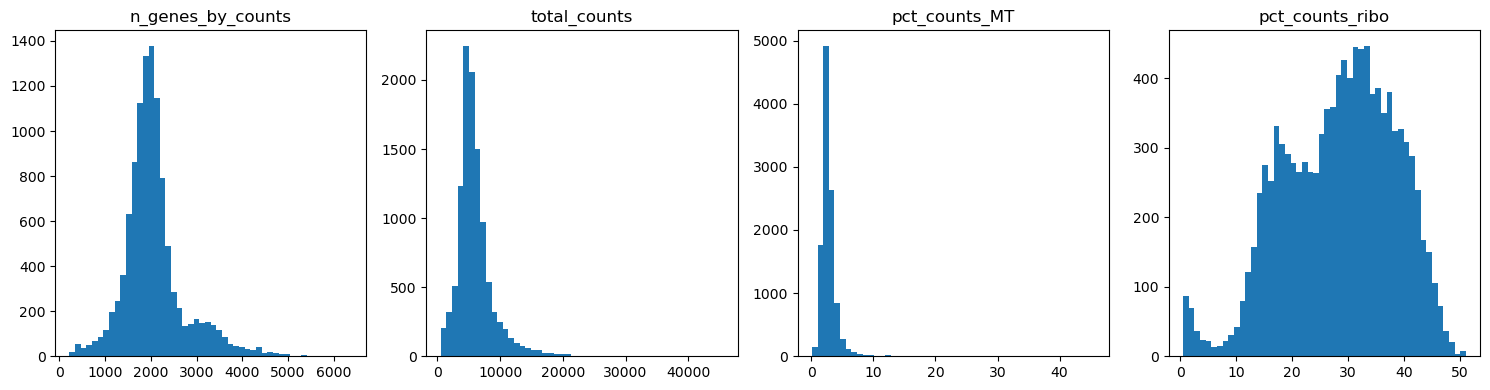

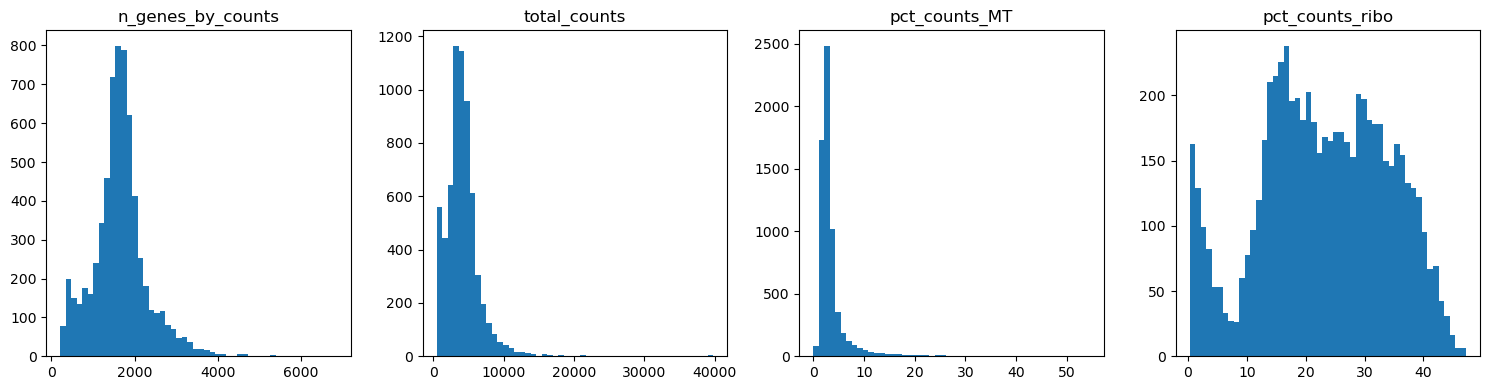

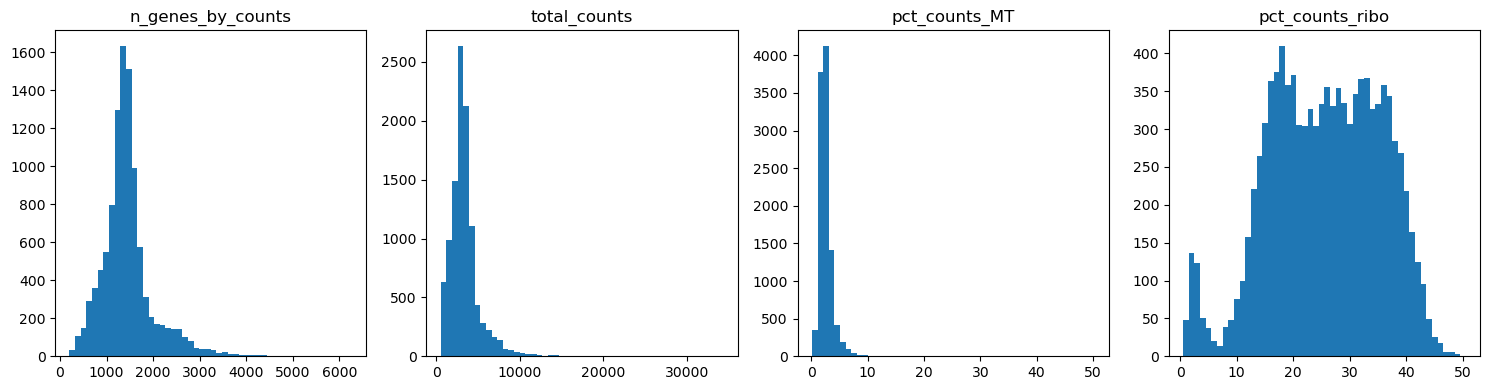

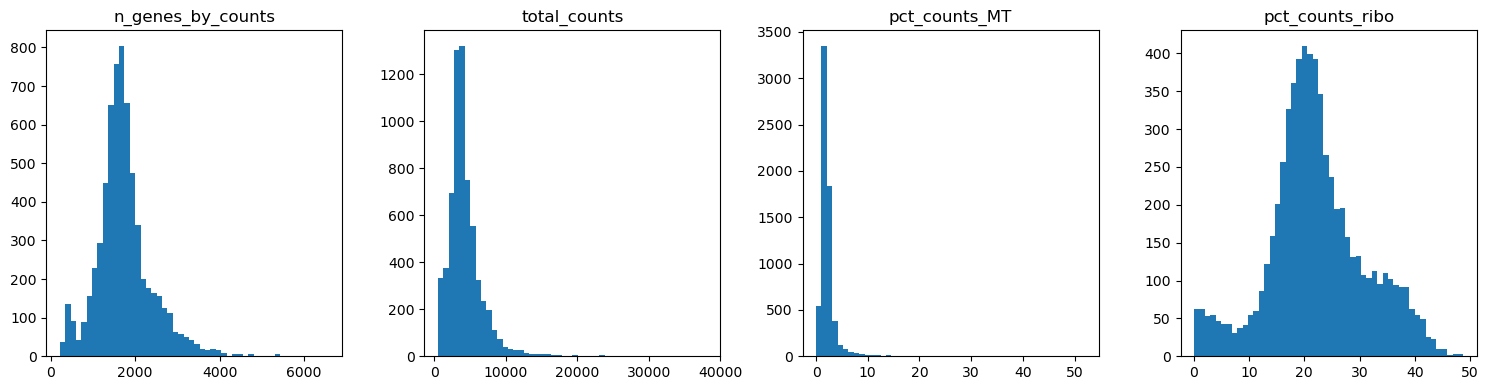

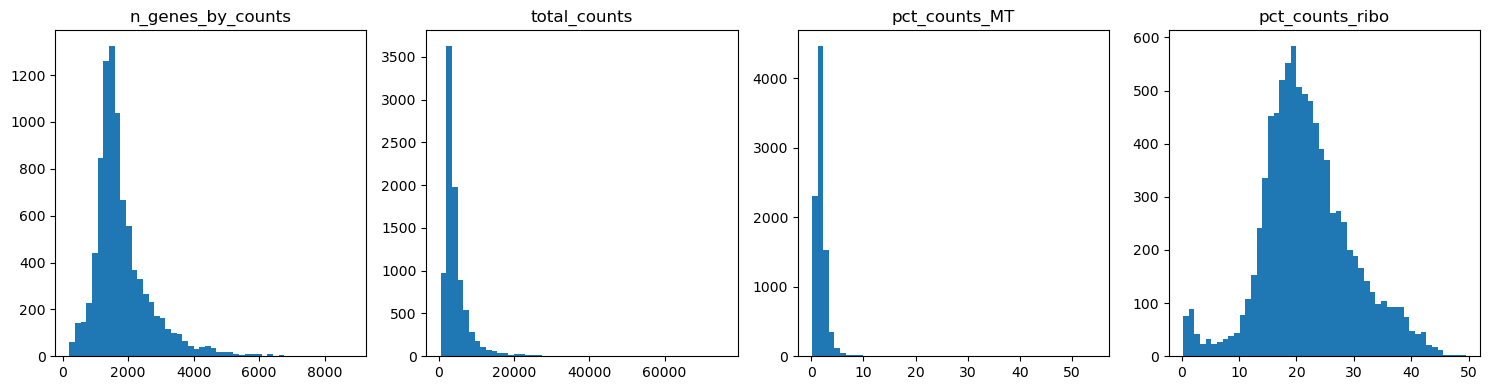

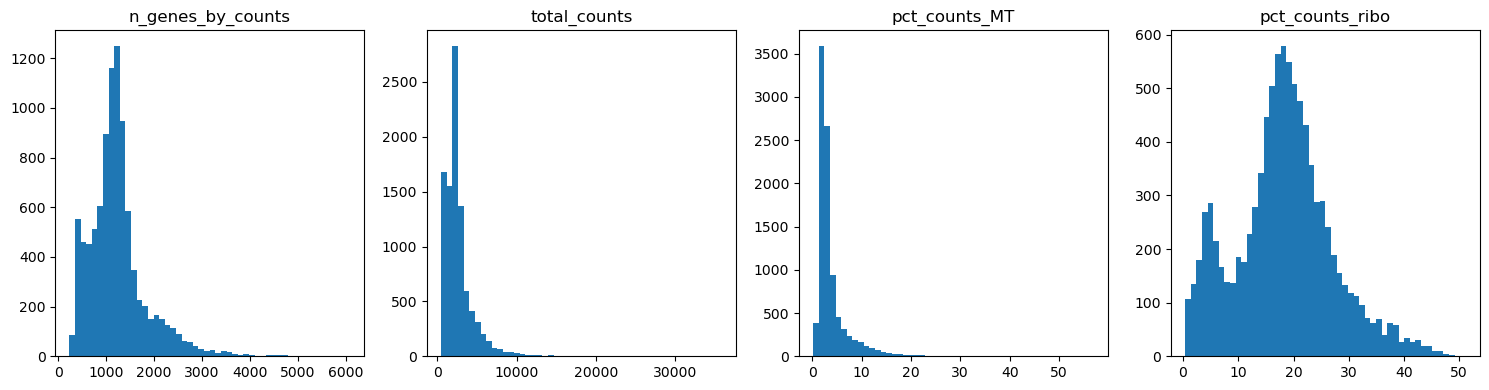

In [7]:
# Histogram of the cell quality

for adata in [normal_1, normal_2, normal_3, hiv_1, hiv_2, hiv_3]:
    fig, ax = plt.subplots(nrows=1, ncols=4, figsize=(15, 4))
    n_bins = 50
    ax[0].hist(adata.obs.n_genes_by_counts, bins = n_bins)
    ax[0].set_title("n_genes_by_counts")
    ax[1].hist(adata.obs.total_counts, bins = n_bins)
    ax[1].set_title("total_counts")
    # ax[2].hist(adata.obs.pct_counts_Malat1, bins=50)
    # ax[2].set_title("pct_counts_MALAT1")
    ax[3].hist(adata.obs.pct_counts_ribo, bins = n_bins)
    ax[3].set_title("pct_counts_ribo")
    # ax[1].hist(adata.obs.pct_counts_hb, bins=50)
    # ax[1].set_title("pct_counts_hb")
    ax[2].hist(adata.obs.pct_counts_MT, bins = n_bins)
    ax[2].set_title("pct_counts_MT")

    plt.tight_layout()
    plt.show

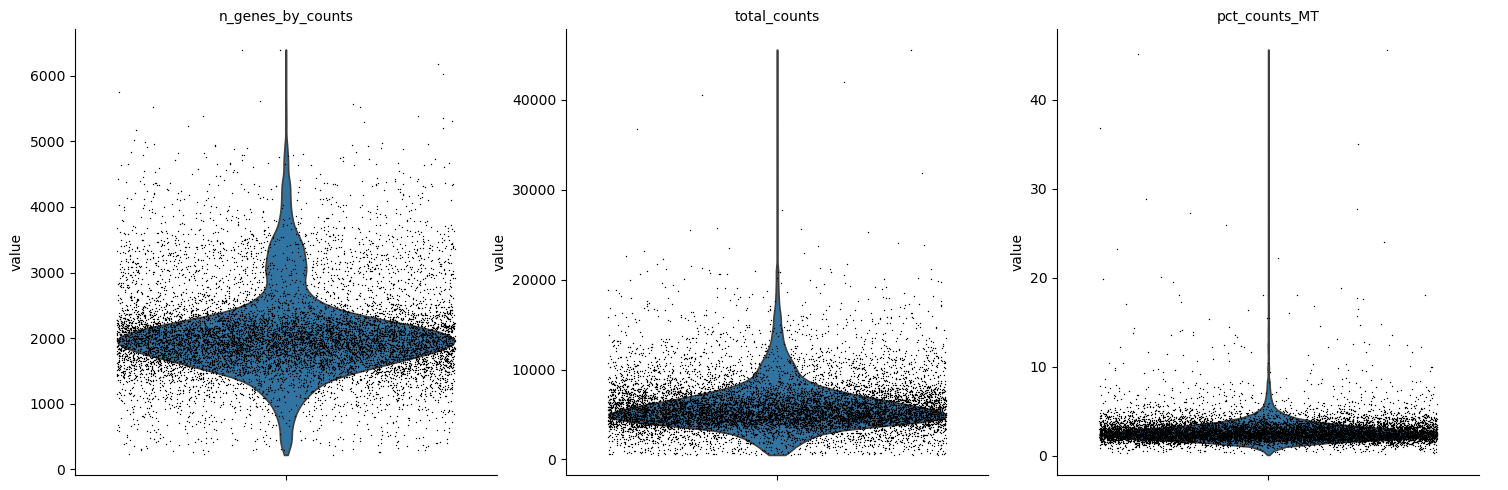

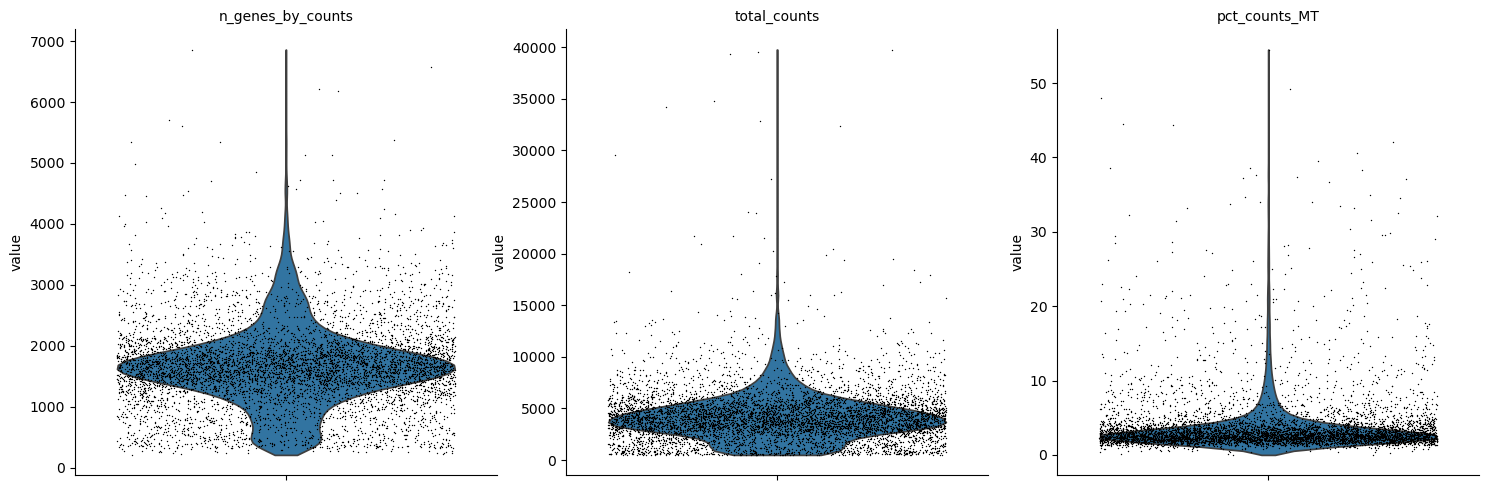

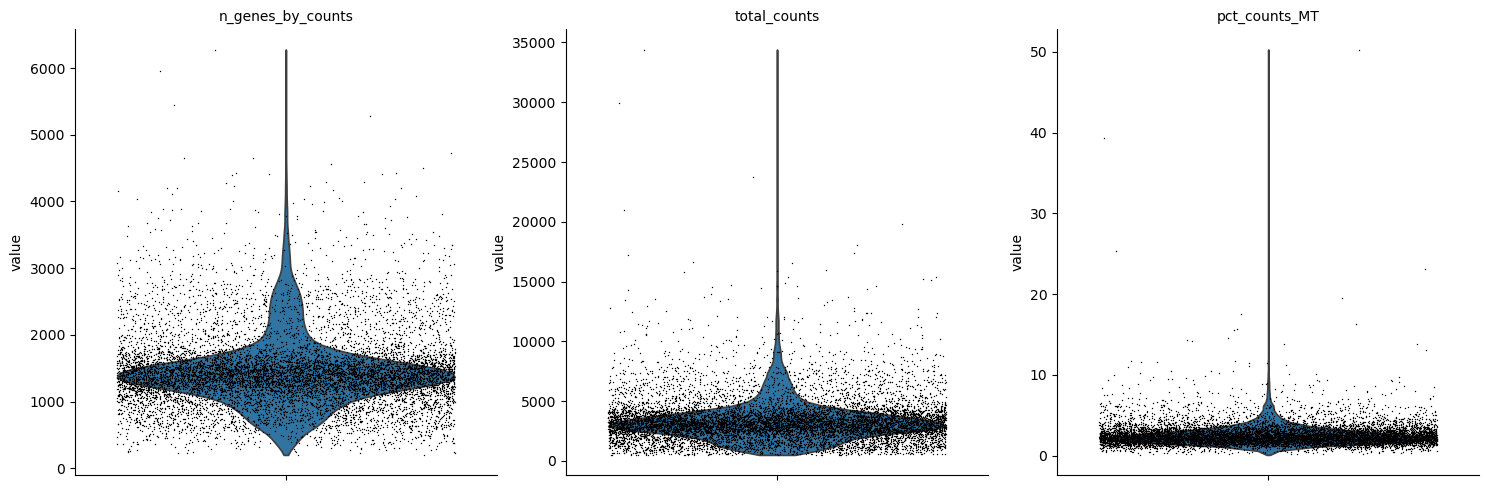

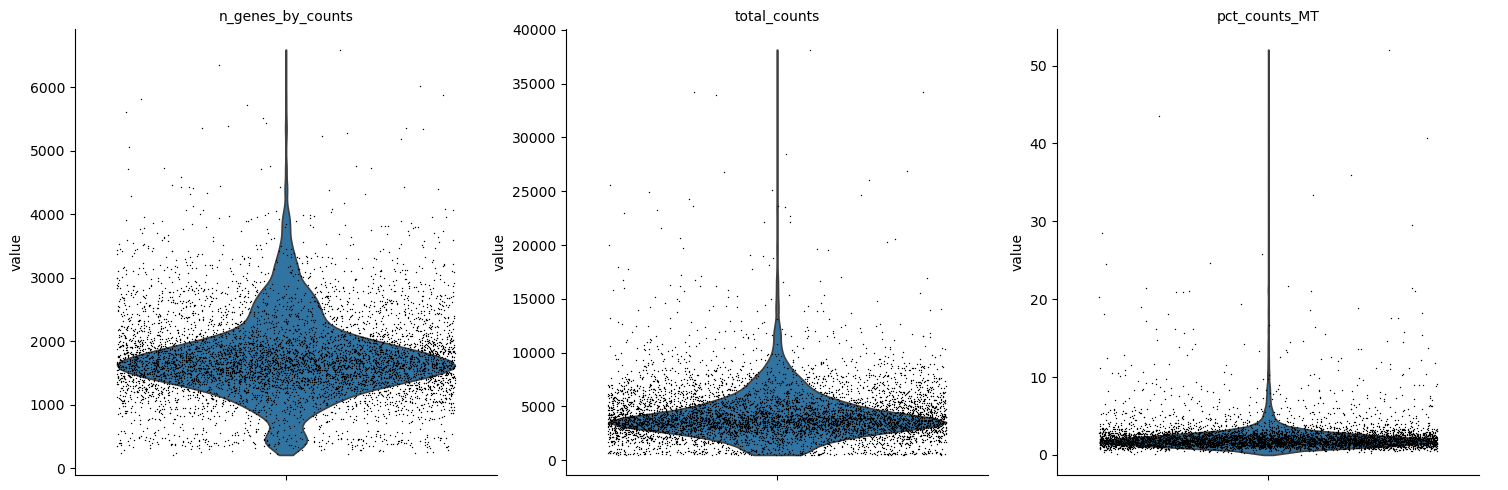

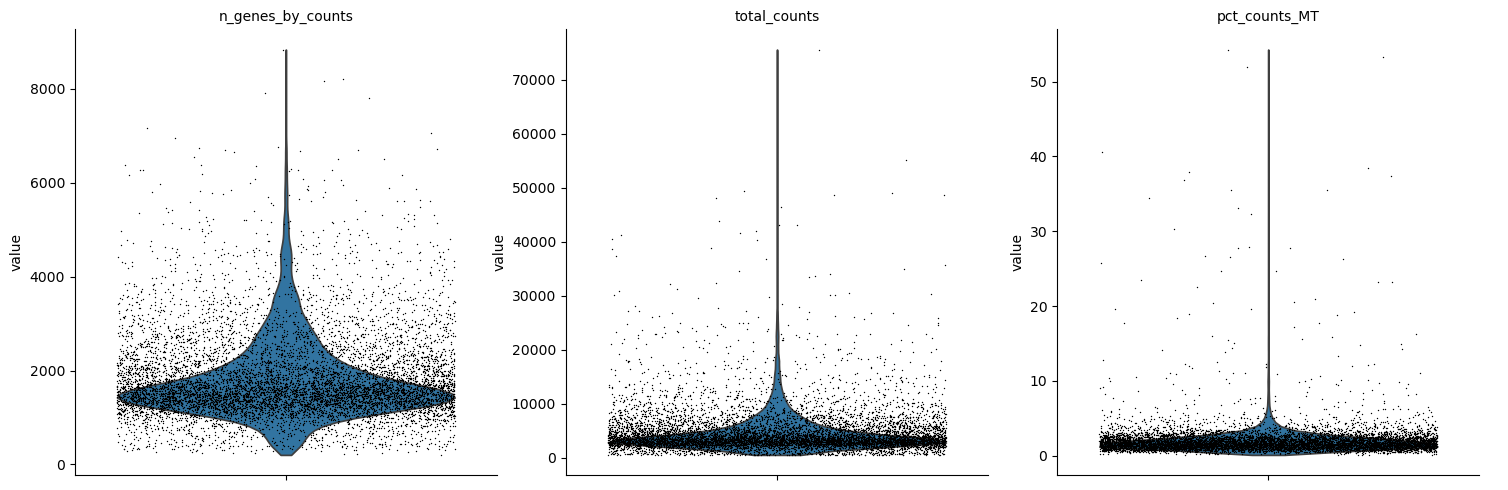

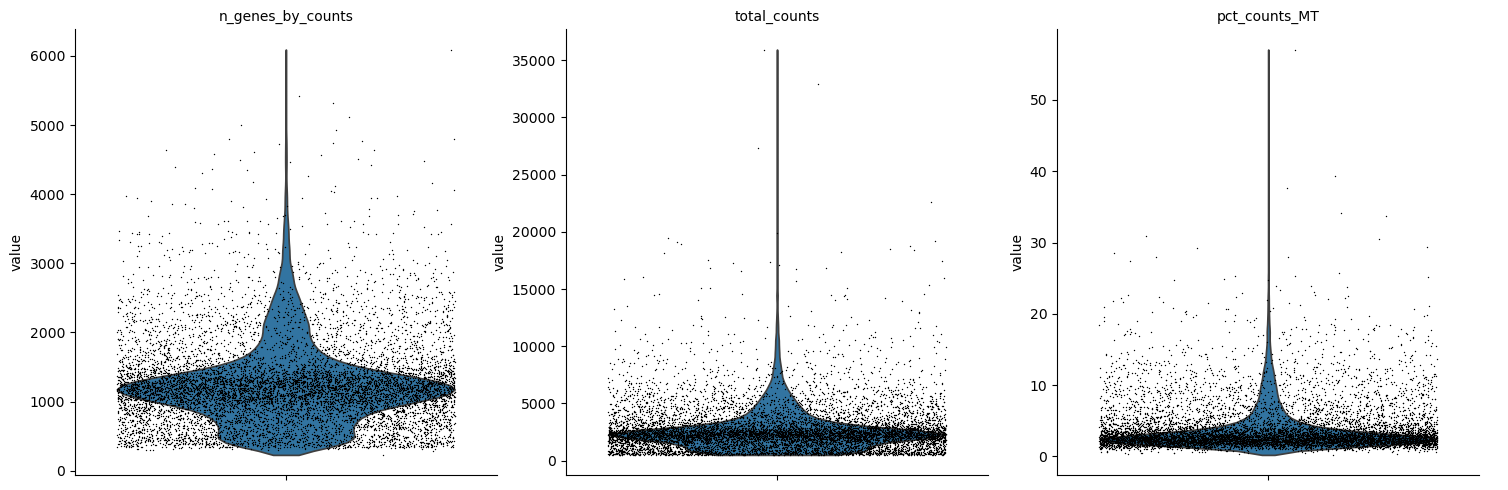

In [8]:
# violin plot of the cell quality

for adata in [normal_1, normal_2, normal_3, hiv_1, hiv_2, hiv_3]:
    sc.pl.violin(
        adata,
        ["n_genes_by_counts", "total_counts", "pct_counts_MT"],
        jitter=0.4,
        multi_panel=True
    )

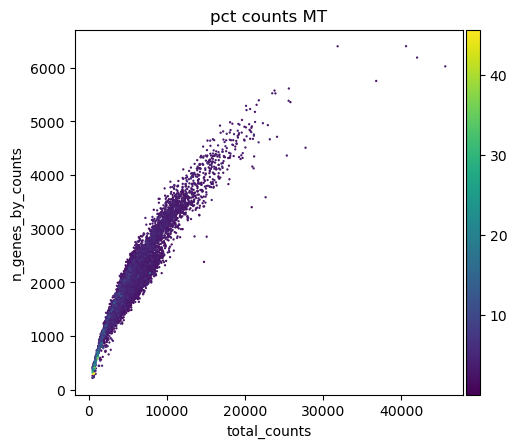

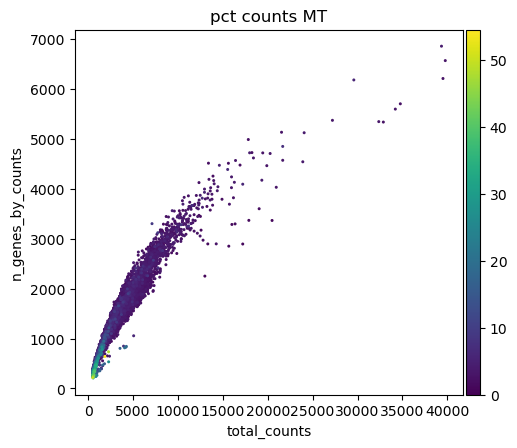

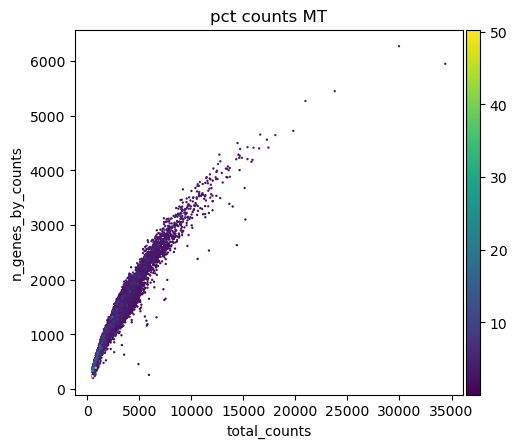

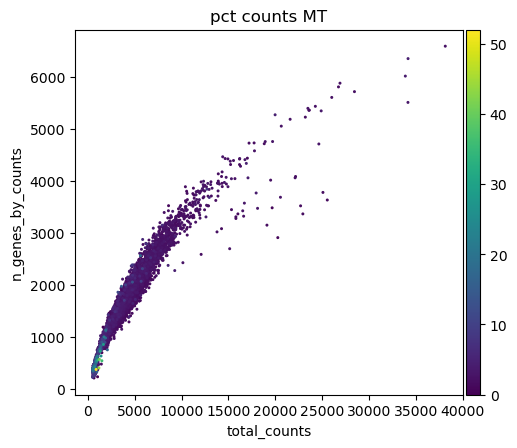

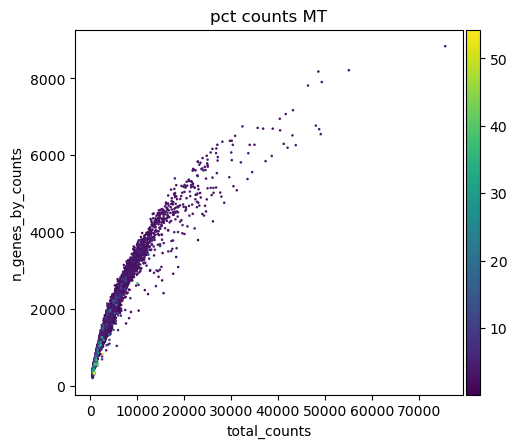

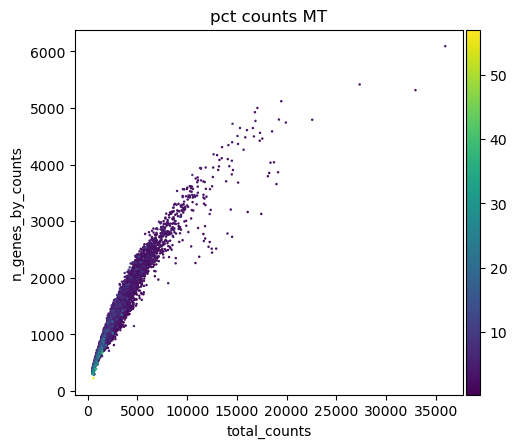

In [9]:
# scatterplot of the cell quality

rcParams['figure.figsize'] = 5, 5 # width, height

for adata in [normal_1, normal_2, normal_3, hiv_1, hiv_2, hiv_3]:
    # plt.figure(figsize=(5, 5))
    sc.pl.scatter(
        adata,
        "total_counts",
        "n_genes_by_counts",
        color="pct_counts_MT"
    )
    # plt.show()
 

## MAD filtering

In [10]:
# Calculate MAD
# https://tomorrow-lab.github.io/posts/drylab/python_scRNA_QC.html

# Calculate MAD
def is_outlier(adata, metric: str, nmads: int):
    M = adata.obs[metric]
    outlier = (M < np.median(M) - nmads * scipy.stats.median_abs_deviation(M)) | (
        np.median(M) + nmads * scipy.stats.median_abs_deviation(M) < M
    )
    return outlier

# Check the outliers
for adata in [normal_1, normal_2, normal_3, hiv_1, hiv_2, hiv_3]:
    adata.obs["outlier"] = (
        is_outlier(adata, "log1p_total_counts", 5)
        | is_outlier(adata, "log1p_n_genes_by_counts", 5)
        | is_outlier(adata, "pct_counts_in_top_20_genes", 5)
    )
    print(adata.obs.outlier.value_counts(), "\n")

# Check the outliers for MT
for adata in [normal_1, normal_2, normal_3, hiv_1, hiv_2, hiv_3]:
    adata.obs["MT_outlier"] = is_outlier(adata, "pct_counts_MT", 3) |(
        adata.obs["pct_counts_MT"] > 8
    )
    print(adata.obs.MT_outlier.value_counts(), "\n")

outlier
False    10363
True       548
Name: count, dtype: int64 

outlier
False    5883
True      564
Name: count, dtype: int64 

outlier
False    9854
True      627
Name: count, dtype: int64 

outlier
False    6130
True      368
Name: count, dtype: int64 

outlier
False    8513
True      431
Name: count, dtype: int64 

outlier
False    9031
True      394
Name: count, dtype: int64 

MT_outlier
False    9854
True     1057
Name: count, dtype: int64 

MT_outlier
False    5493
True      954
Name: count, dtype: int64 

MT_outlier
False    9432
True     1049
Name: count, dtype: int64 

MT_outlier
False    5875
True      623
Name: count, dtype: int64 

MT_outlier
False    8211
True      733
Name: count, dtype: int64 

MT_outlier
False    7722
True     1703
Name: count, dtype: int64 



## Actual filtering using MAD

In [11]:
# Filter out the outliers
def MAD_filtering (adata):
    print(f"Cell number before filtering: {adata.n_obs}")
    adata = adata[(~adata.obs.outlier) & (~adata.obs.MT_outlier)]
    
    print(f"Cell number after filtering: {adata.n_obs}")
    print()
    return adata

normal_1 = MAD_filtering(normal_1)
normal_2 = MAD_filtering(normal_2)
normal_3 = MAD_filtering(normal_3)
hiv_1 = MAD_filtering(hiv_1)
hiv_2 = MAD_filtering(hiv_2)
hiv_3 = MAD_filtering(hiv_3)

Cell number before filtering: 10911
Cell number after filtering: 9543

Cell number before filtering: 6447
Cell number after filtering: 5385

Cell number before filtering: 10481
Cell number after filtering: 9022

Cell number before filtering: 6498
Cell number after filtering: 5755

Cell number before filtering: 8944
Cell number after filtering: 7979

Cell number before filtering: 9425
Cell number after filtering: 7606



# Transient clustering for SoupX

In [ ]:
from scipy.sparse import csc_matrix, save_npz

def preprocessing_data_to_r (adata, annotation):
    adata_pp = adata.copy() # copy adata to other variant
    sc.pp.normalize_per_cell(adata_pp)  # normalize RNA count
    sc.pp.log1p(adata_pp)   # calculate log1p
    sc.pp.pca(adata_pp) # PCA calculation
    sc.pp.neighbors(adata_pp) # neighboring
    sc.tl.leiden(adata_pp, key_added="soupx_groups") # leiden clustering

    # 클러스터를 .obs에 soupx_groups로 추가하고 벡터로 저장합니다.
    soupx_groups = adata_pp.obs["soupx_groups"]

    # AnnData 객체의 복사본을 삭제해 메모리를 절약합니다.
    del adata_pp

    # 세포, 유전자, 필터링된 카운터 행렬을 저장합니다.
    # SoupX에는 모양 특징 x 바코드 행렬이 필요하므로 transpose해야 합니다.
    cells = adata.obs_names
    genes = adata.var_names
    data = adata.X.T
    
    # Save data in "./data_to_r/" folder for further analysis
    # 경로 설정
    directory = '../file_to_r/'

    # 경로가 존재하지 않으면 생성
    if not os.path.exists(directory):
        os.makedirs(directory)
        
    # 5. 파일명 생성
    filename_cells = f"{annotation}_cells.csv"
    filepath_cells = os.path.join(directory, filename_cells)
    filename_genes = f"{annotation}_genes.csv"
    filepath_genes = os.path.join(directory, filename_genes)
    filename_data = f"{annotation}_data.npz"
    filepath_data = os.path.join(directory, filename_data)

    # 6. Feather 파일로 저장
    cells.to_series().to_csv(filepath_cells, index=False, header=['Index'])
    genes.to_series().to_csv(filepath_genes, index=False, header=['Index'])
    save_npz(filepath_data, data)

    print(f"DataFrame is saved as {filepath_cells}")
    print(f"DataFrame is saved as {filepath_genes}")
    print(f"DataFrame is saved as {filepath_data}")

In [ ]:
preprocessing_data_to_r(normal_1, "normal_1")

In [ ]:
# save raw_feature_bc_matrix.h5 for further analysis in r
data_path = "../../OneDrive/Documents/scData/hiv/raw_data/"

def load_data (file_name):
    tdata = sc.read_10x_h5(data_path + file_name)
    
    tdata.var_names_make_unique()
    
    # print(f"The shape of the dataset: n_obs {tdata.shape[0]} x n_vars {tdata.shape[1]}.")
    # print("Init barcode count:", tdata.shape[0])
    # print("Init_gene_count:", tdata.shape[1], "\n")
    return tdata.X.T
    
normal_1_tod = load_data("normal_1_raw_feature_bc_matrix.h5")
normal_2_tod = load_data("normal_2_raw_feature_bc_matrix.h5")
normal_3_tod = load_data("normal_3_raw_feature_bc_matrix.h5")

In [ ]:
type(normal_1_tod)

# Doublet removing using scDblFinder

In [12]:
# for run R code in jupyter notebook
import os
os.environ['R_HOME'] = "C:/Users/heung/anaconda3/Lib/R"

In [13]:
# to use R in jupyter notebook
import anndata2ri
import logging

import rpy2.rinterface_lib.callbacks as rcb
import rpy2.robjects as ro
from rpy2.robjects.packages import importr, PackageNotInstalledError

rcb.logger.setLevel(logging.ERROR)
ro.pandas2ri.activate()
anndata2ri.activate

%load_ext rpy2.ipython

c:\Users\heung\anaconda3\Lib\site-packages\rpy2\robjects\packages.py:367: UserWarning: The symbol 'quartz' is not in this R namespace/package.
  warnings.warn(


In [14]:
normal_1_t = anndata2ri.py2rpy(normal_1.X.T)
normal_2_t = anndata2ri.py2rpy(normal_2.X.T)
normal_3_t = anndata2ri.py2rpy(normal_3.X.T)
hiv_1_t = anndata2ri.py2rpy(hiv_1.X.T)
hiv_2_t = anndata2ri.py2rpy(hiv_2.X.T)
hiv_3_t = anndata2ri.py2rpy(hiv_3.X.T)

In [15]:
%%R -i normal_1_t,normal_2_t,normal_3_t,hiv_1_t,hiv_2_t,hiv_3_t

saveRDS(normal_1_t, "../file_to_r/normal_1_t.rds")
saveRDS(normal_2_t, "../file_to_r/normal_2_t.rds")
saveRDS(normal_3_t, "../file_to_r/normal_3_t.rds")
saveRDS(hiv_1_t, "../file_to_r/hiv_1_t.rds")
saveRDS(hiv_2_t, "../file_to_r/hiv_2_t.rds")
saveRDS(hiv_3_t, "../file_to_r/hiv_3_t.rds")

여기서 R로 갔다가 scDblFinder 돌리고 다시 돌아옴

In [16]:
%%R -o normal_1_dbl_score -o normal_1_dbl_class -o normal_2_dbl_score -o normal_2_dbl_class -o normal_3_dbl_score -o normal_3_dbl_class -o hiv_1_dbl_score -o hiv_1_dbl_class -o hiv_2_dbl_score -o hiv_2_dbl_class -o hiv_3_dbl_score -o hiv_3_dbl_class

# Load libraries
normal_1_dbl_score <- readRDS("../file_to_py/normal_1_dbl_score.rds")
normal_1_dbl_class <- readRDS("../file_to_py/normal_1_dbl_class.rds")
normal_2_dbl_score <- readRDS("../file_to_py/normal_2_dbl_score.rds")
normal_2_dbl_class <- readRDS("../file_to_py/normal_2_dbl_class.rds")
normal_3_dbl_score <- readRDS("../file_to_py/normal_3_dbl_score.rds")
normal_3_dbl_class <- readRDS("../file_to_py/normal_3_dbl_class.rds")

hiv_1_dbl_score <- readRDS("../file_to_py/hiv_1_dbl_score.rds")
hiv_1_dbl_class <- readRDS("../file_to_py/hiv_1_dbl_class.rds")
hiv_2_dbl_score <- readRDS("../file_to_py/hiv_2_dbl_score.rds")
hiv_2_dbl_class <- readRDS("../file_to_py/hiv_2_dbl_class.rds")
hiv_3_dbl_score <- readRDS("../file_to_py/hiv_3_dbl_score.rds")
hiv_3_dbl_class <- readRDS("../file_to_py/hiv_3_dbl_class.rds")

In [17]:
# Save the result as adata.obs
normal_1.obs["scDblFinder_score"] = normal_1_dbl_score
normal_1.obs["scDblFinder_class"] = normal_1_dbl_class
normal_2.obs["scDblFinder_score"] = normal_2_dbl_score
normal_2.obs["scDblFinder_class"] = normal_2_dbl_class
normal_3.obs["scDblFinder_score"] = normal_3_dbl_score
normal_3.obs["scDblFinder_class"] = normal_3_dbl_class

hiv_1.obs["scDblFinder_score"] = hiv_1_dbl_score
hiv_1.obs["scDblFinder_class"] = hiv_1_dbl_class
hiv_2.obs["scDblFinder_score"] = hiv_2_dbl_score
hiv_2.obs["scDblFinder_class"] = hiv_2_dbl_class
hiv_3.obs["scDblFinder_score"] = hiv_3_dbl_score
hiv_3.obs["scDblFinder_class"] = hiv_3_dbl_class

C:\Users\heung\AppData\Local\Temp\ipykernel_64756\3869878917.py:2: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  normal_1.obs["scDblFinder_score"] = normal_1_dbl_score
C:\Users\heung\AppData\Local\Temp\ipykernel_64756\3869878917.py:4: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  normal_2.obs["scDblFinder_score"] = normal_2_dbl_score
C:\Users\heung\AppData\Local\Temp\ipykernel_64756\3869878917.py:6: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  normal_3.obs["scDblFinder_score"] = normal_3_dbl_score
C:\Users\heung\AppData\Local\Temp\ipykernel_64756\3869878917.py:9: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  hiv_1.obs["scDblFinder_score"] = hiv_1_dbl_score
C:\Users\heung\AppData\Local\Temp\ipykernel_64756\3869878917.py:11: ImplicitModificationWarning: Trying to

In [18]:
print(type(normal_1.obs.scDblFinder_score))


print(type(hiv_1.obs))
print(type(hiv_1.obs.scDblFinder_score))

<class 'pandas.core.series.Series'>
<class 'pandas.core.frame.DataFrame'>
<class 'pandas.core.series.Series'>


In [19]:
# Check the result

print(normal_1.obs.scDblFinder_class.value_counts(), "\n")
print(normal_2.obs.scDblFinder_class.value_counts(), "\n")
print(normal_3.obs.scDblFinder_class.value_counts(), "\n")
print(hiv_1.obs.scDblFinder_class.value_counts(), "\n")
print(hiv_2.obs.scDblFinder_class.value_counts(), "\n")
print(hiv_3.obs.scDblFinder_class.value_counts(), "\n")

scDblFinder_class
singlet    8839
doublet     704
Name: count, dtype: int64 

scDblFinder_class
singlet    5096
doublet     289
Name: count, dtype: int64 

scDblFinder_class
singlet    8290
doublet     732
Name: count, dtype: int64 

scDblFinder_class
singlet    5456
doublet     299
Name: count, dtype: int64 

scDblFinder_class
singlet    7209
doublet     770
Name: count, dtype: int64 

scDblFinder_class
singlet    6938
doublet     668
Name: count, dtype: int64 



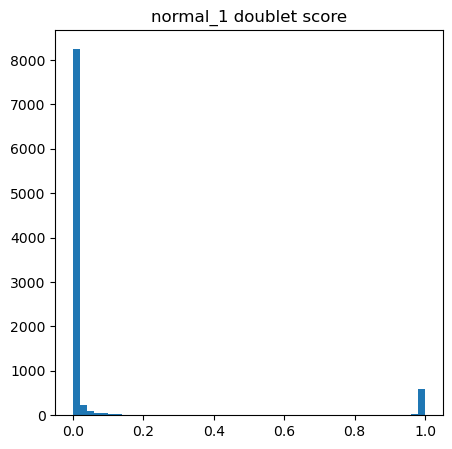

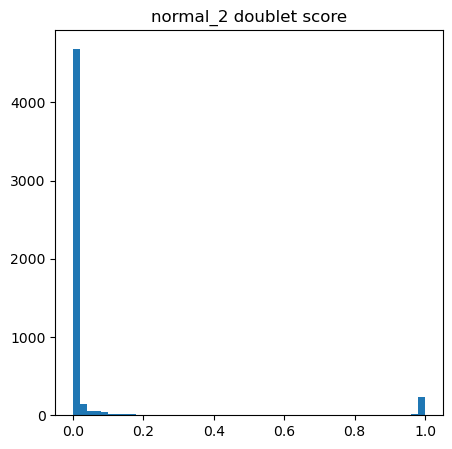

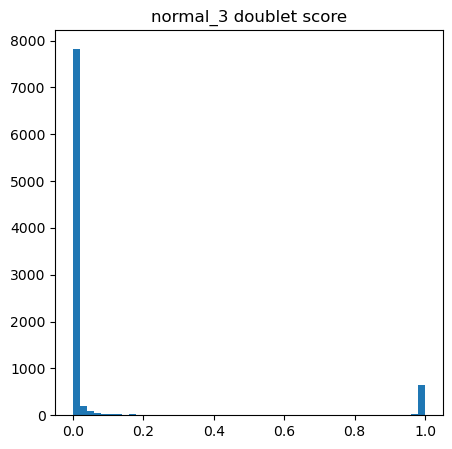

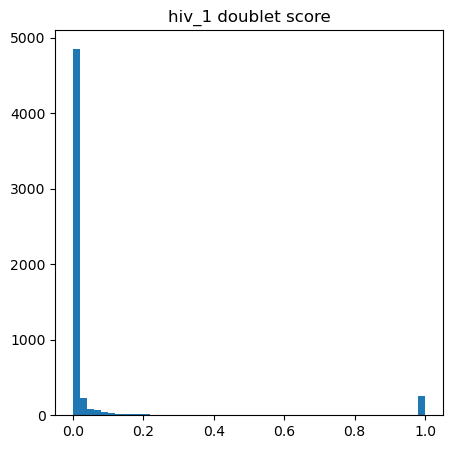

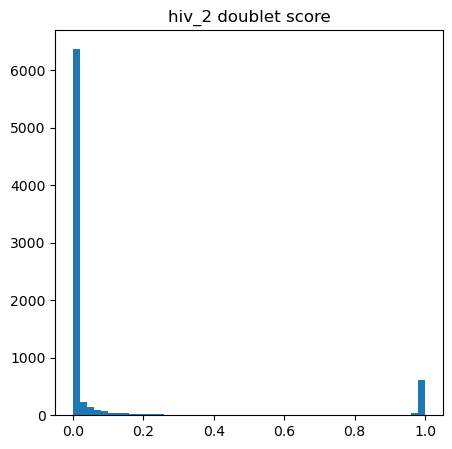

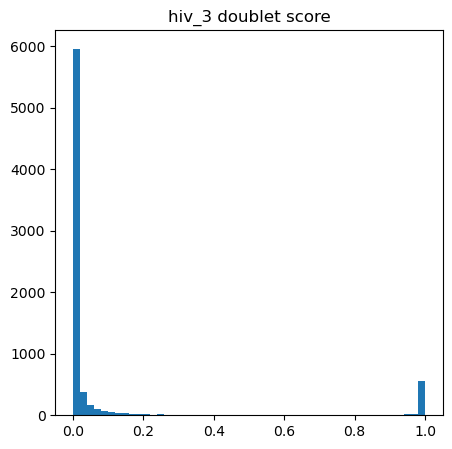

In [20]:
# Doublet score histogram

plt.figure()
plt.hist(normal_1.obs.scDblFinder_score, bins=50)
plt.title("normal_1 doublet score")
plt.show()

plt.figure()
plt.hist(normal_2.obs.scDblFinder_score, bins=50)
plt.title("normal_2 doublet score")
plt.show()

plt.figure()
plt.hist(normal_3.obs.scDblFinder_score, bins=50)
plt.title("normal_3 doublet score")
plt.show()

plt.figure()
plt.hist(hiv_1.obs.scDblFinder_score, bins=50)
plt.title("hiv_1 doublet score")
plt.show()

plt.figure()
plt.hist(hiv_2.obs.scDblFinder_score, bins=50)
plt.title("hiv_2 doublet score")
plt.show()

plt.figure()
plt.hist(hiv_3.obs.scDblFinder_score, bins=50)
plt.title("hiv_3 doublet score")
plt.show()

In [ ]:
# save quality controled files

normal_1.write("../qc_files/normal_1_quality_control.h5ad")
normal_2.write("../qc_files/normal_2_quality_control.h5ad")
normal_3.write("../qc_files/normal_3_quality_control.h5ad")
hiv_1.write("../qc_files/hiv_1_quality_control.h5ad")
hiv_2.write("../qc_files/hiv_2_quality_control.h5ad")
hiv_3.write("../qc_files/hiv_3_quality_control.h5ad")